<a href="https://colab.research.google.com/github/leonardo3108/IA368dd/blob/main/exercicios/Aula_7/Aula_7_DPR_TesteOverfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
nome = 'Leonardo Augusto da Silva Pacheco'
print(f'Meu nome é {nome}')

Meu nome é Leonardo Augusto da Silva Pacheco


# Enunciado - Fazer finetuning de um buscador denso

Usar como treino o dataset "tiny" do MS MARCO
https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv

Avaliar o modelo no TREC-COVID, e comparar os resultados com o BM25 e doc2query

Comparar busca "exaustiva" (semelhança do vetor query com todos os vetores do corpus) com a busca aproximada (Approximate Nearest Neighbor - ANN)

Para a busca aproximada, usar os algoritmos existentes na biblioteca sentence-transformers (ex: hnswlib) OU implemente um você mesmo (Bonus!)

Dicas:

- Usar a média dos vetores da última camada (conhecido como mean pooling) do transformer para representar queries e passagens; Alternativamente, usar apenas o vetor do [CLS] da última cada.

- Tente inicialmente uma loss facil de implementar, como a entropia-cruzada

- Começar o treino a partir do microsoft/MiniLM-L12-H384-uncased

- Avaliar o pipeline usando um modelo já bem treinado: sentence-transformers/all-mpnet-base-v2

- Comparar resultados usando semelhança de coseno e produto escalar como funções de similaridade

- Para checar se seu codigo de avaliação está correto, comparar o seu desempenho com o do modelo já treinado no MS MARCO: https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2; O nDCG@10 no TREC-COVID deve ser ~0.47

- Usar a biblioteca do sentence-transformers para avaliar o modelo


# Setup

## Hiperparâmetros

In [2]:
max_length = 256
lr = 2e-5
train_mode = 'overfit'   # 'full' / 'dev' / 'overfit'
train_size = 10000
eval_size = 1000
batch_size = 32
epochs = 15

model_name = "microsoft/MiniLM-L12-H384-uncased"
model_output_dir='model_output'

In [3]:
if train_mode != 'full':
    batch_size = 10
    if train_mode == 'dev':
        train_size = 100
        eval_size = 10
        epochs = 3
    elif train_mode == 'overfit':
        train_size = 10
        epochs = 100

print('train_mode:', train_mode, '\ttrain_size:', train_size, ' \teval_size:', eval_size, '\nbatch_size:', batch_size, '  \tepochs:', epochs)        

train_mode: overfit 	train_size: 10  	eval_size: 1000 
batch_size: 10   	epochs: 100


## Instalação de libs

In [4]:
!pip install transformers 
!pip install datasets
!pip install ftfy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.6 MB/s eta 0:00:0

## Importação de libs

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import ftfy
import torch
import os
from pathlib import Path
from torch.utils import data
from torch.utils.data import DataLoader
from transformers import AdamW, AutoModel, AutoTokenizer, BatchEncoding, get_cosine_with_hard_restarts_schedule_with_warmup, get_linear_schedule_with_warmup, Trainer, TrainingArguments
from tqdm.auto import tqdm

## Sementes

In [6]:
np.random.seed(42)

## Utilização de GPUs

In [7]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [8]:
if dev != 'cpu':
    !nvidia-smi

Tue Apr 18 22:47:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preparação dos dados

## Obtenção

In [9]:
!wget -nc 'https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv'

--2023-04-18 22:47:16--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  --.-KB/s    in 0.07s   

2023-04-18 22:47:16 (107 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]



## Tratamento

In [10]:
df_msmarco = pd.read_csv("msmarco_triples.train.tiny.tsv", sep='\t', names=['query', 'passage', 'not_relevant'], header=None)
df_msmarco['query'] = df_msmarco['query'].apply(ftfy.fix_text)
df_msmarco['passage'] = df_msmarco['passage'].apply(ftfy.fix_text)
del df_msmarco['not_relevant']
df_msmarco

,query,passage
0,is a little caffeine ok during pregnancy,We don't know a lot about the effects of caffe...
1,what fruit is native to australia,Passiflora herbertiana. A rare passion fruit n...
2,how large is the canadian military,The Canadian Armed Forces. 1 The first large-...
3,types of fruit trees,Cherry. Cherry trees are found throughout the ...
4,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,..."
...,...,...
10995,where is maramal in skyrim,I'm having a rather difficult time in Skyrim t...
10996,which is a basic unit of a sugar molecule,The basic unit of carbohydrate is a single sug...
10997,deloitte consulting or phone number,A: The phone number for Deloitte Consulting Ll...
10998,"how many hours a day to work to get lunch in ,a","In the United States, most states require a mi..."


## Split

In [11]:
eval_indexes = np.random.choice(len(df_msmarco), eval_size, replace=False)
df_eval = df_msmarco.iloc[eval_indexes].reset_index(drop=True)
df_eval

,query,passage
0,where to get corso riggs,Background. Always cheerful and eternally opti...
1,what rivers flow into the wabash river,The Wabash River rises south of Grand Lake abo...
2,where is fiji islands,1 The Fiji Islands are an archipelago of over ...
3,how long do nipple piercings take to heal,"Typically, nipple piercings take anywhere from..."
4,what is a pole pocket banner,Pole pockets on banners are something that can...
...,...,...
995,what causes malar festoons: \,"Dr. Amiya Prasad, an oculofacial cosmetic surg..."
996,loyalty review system definition,Loyalty represents a feeling of attachment to ...
997,average rate for pressure washing,Find out how much your project will cost. Prov...
998,what do the words honor and loyalty mean,"Honor is a matter of carrying out, acting, and..."


In [12]:
train_indexes = np.setdiff1d(list(df_msmarco.index), eval_indexes)[:train_size]
df_train = df_msmarco.iloc[train_indexes].reset_index(drop=True)
df_train

,query,passage
0,is a little caffeine ok during pregnancy,We don't know a lot about the effects of caffe...
1,what fruit is native to australia,Passiflora herbertiana. A rare passion fruit n...
2,how large is the canadian military,The Canadian Armed Forces. 1 The first large-...
3,how many calories a day are lost breastfeeding,"Not only is breastfeeding better for the baby,..."
4,where is harrison city pa,Harrison City is a census-designated place (CD...
5,how many representatives does texas have,Representatives. The United States is divided ...
6,major climate characteristics of tropical rain...,Description [edit]. Tropical rainforests have ...
7,cancer of the pancreas symptoms,Symptoms of Pancreatic Cancer. Pancreatic canc...
8,foods that will help lower blood sugar,Lemons are rich in Vitamin C and their acidity...
9,"what county is williamsport, pa",Williamsport Sheriff. Find Williamsport Pennsy...


## Listas de queries e de passagens

In [13]:
queries_train = df_train['query'].tolist()
passages_train = df_train['passage'].tolist()
queries_val = df_eval['query'].tolist()
passages_val = df_eval['passage'].tolist()

print(f'Treinamento: {len(queries_train)} queries, {len(passages_train)} passagens')
print(f'Validação:   {len(queries_val)} queries, {len(passages_val)} passagens')

Treinamento: 10 queries, 10 passagens
Validação:   1000 queries, 1000 passagens


In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Criação dos datasets

In [15]:
class DatasetDPR(data.Dataset):
    def __init__(self, tokenizer, texts, max_seq_length = max_length):
        self.max_seq_length = max_seq_length
        self.tokenizer = tokenizer
        self.texts = texts
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        return self.tokenizer(self.texts[idx], padding=True, truncation=True, max_length=self.max_seq_length)

In [16]:
dataset_queries_train = DatasetDPR(tokenizer, queries_train)
dataset_passages_train = DatasetDPR(tokenizer, passages_train)
dataset_queries_val = DatasetDPR(tokenizer, queries_val)
dataset_passages_val = DatasetDPR(tokenizer, passages_val)

len(dataset_queries_train), len(dataset_passages_train), len(dataset_queries_val), len(dataset_passages_val)

(10, 10, 1000, 1000)

In [17]:
print('Example from train dataset:')
print(f'{queries_train[0]}: {dataset_queries_train[0]}')
print(f'{passages_train[0][:80]}...: {dataset_passages_train[0]}')
print('decode:', ' '.join(tokenizer.batch_decode(dataset_passages_train[0]['input_ids'], skip_special_tokens=True)))
print('\nExample from val dataset:')
print(f'{queries_val[0]}: {dataset_queries_val[0]}')
print(f'{passages_val[0][:80]}...: {dataset_passages_val[0]}')
print('decode:', ' '.join(tokenizer.batch_decode(dataset_passages_val[0]['input_ids'], skip_special_tokens=True)))

Example from train dataset:
is a little caffeine ok during pregnancy: {'input_ids': [101, 2003, 1037, 2210, 24689, 7959, 3170, 7929, 2076, 10032, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
We don't know a lot about the effects of caffeine during pregnancy on you and yo...: {'input_ids': [101, 2057, 2123, 1005, 1056, 2113, 1037, 2843, 2055, 1996, 3896, 1997, 24689, 7959, 3170, 2076, 10032, 2006, 2017, 1998, 2115, 3336, 1012, 2061, 2009, 1005, 1055, 2190, 2000, 5787, 1996, 3815, 2017, 2131, 2169, 2154, 1012, 2065, 2017, 1005, 2128, 6875, 1010, 5787, 24689, 7959, 3170, 2000, 3263, 4971, 8004, 6444, 2015, 2169, 2154, 1012, 2023, 2003, 2055, 1996, 3815, 1999, 1015, 13714, 1022, 1011, 19471, 10268, 1997, 4157, 2030, 2028, 2260, 1011, 19471, 2452, 1997, 4157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Criação dos Dataloaders

In [18]:
def collate_fn(batch):
    return BatchEncoding(tokenizer.pad(batch, return_tensors='pt'))

In [19]:
dataloader_queries_train = DataLoader(dataset_queries_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_passages_train = DataLoader(dataset_passages_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_queries_val = DataLoader(dataset_queries_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
dataloader_passages_val = DataLoader(dataset_passages_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Treinamento

## Carregamento do modelo pré-treinado

In [20]:
model_queries = AutoModel.from_pretrained(model_name).to(device)
model_passages = AutoModel.from_pretrained(model_name).to(device)

## Cálculo da função de perda

Definida no artigo [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf), seção 3.2 


In [21]:
def compute_loss(outputs_queries, outputs_passages): #paper DPR section 3.2
    # we use two independent BERT networks (base, uncased) and take the representation at the [CLS] token as the output, so d = 768.
    cls_queries  =  outputs_queries.last_hidden_state[:, 0, :]
    cls_passages = outputs_passages.last_hidden_state[:, 0, :]

    # We define the similarity between the question and the passage using the dot product of their vectors (sim(q, p)):
    sim = torch.matmul(cls_queries, torch.transpose(cls_passages, 0, 1))  #Formula 1

    # We optimize the loss function as the negative log likelihood of the positive passage
    esim = torch.exp(sim)
    L = - torch.log(torch.diag(esim) / esim.sum(dim=1)) #Formula 2

    return torch.mean(L)

## Execução

In [22]:
optimizer_queries  = AdamW(model_queries.parameters(), lr=lr)
optimizer_passages = AdamW(model_passages.parameters(), lr=lr)

num_training_steps = epochs * len(dataloader_queries_train)
num_warmup_steps = int(num_training_steps * 0.1)

scheduler_queries  = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer_queries,  num_warmup_steps, num_training_steps)
scheduler_passages = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer_passages, num_warmup_steps, num_training_steps)

history = {'train_loss': [], 'valid_loss': []}

for epoch in tqdm(range(epochs), desc='Epochs'):
    model_queries.train()
    model_passages.train()
    
    train_losses = []
    for batch_queries, batch_passages in tqdm(list(zip(dataloader_queries_train, dataloader_passages_train)), mininterval=0.5, desc='Train', disable=False):
        optimizer_queries.zero_grad()
        optimizer_passages.zero_grad()
        
        outputs_queries  = model_queries(**batch_queries.to(device))
        outputs_passages = model_passages(**batch_passages.to(device))

        loss = compute_loss(outputs_queries, outputs_passages)
        loss.backward()
        
        optimizer_queries.step()
        optimizer_passages.step()

        scheduler_queries.step()
        scheduler_passages.step()

        train_losses.append(loss.detach().cpu().numpy())

    train_loss = np.mean(train_losses)
    history['train_loss'].append(train_loss)
    print(f'Epoch: {epoch + 1}, training loss: {train_loss:0.4f}')
    
    model_queries.eval()
    model_passages.eval()
    eval_losses = []
    with torch.no_grad():
        for batch_queries, batch_passages in tqdm(list(zip(dataloader_queries_val, dataloader_passages_val)), mininterval=0.5, desc="Eval", disable=False):
            outputs_queries  = model_queries(**batch_queries.to(device))
            outputs_passages = model_passages(**batch_passages.to(device))
            eval_losses.append(compute_loss(outputs_queries, outputs_passages).cpu().numpy())

    eval_loss = np.mean(eval_losses)
    history['valid_loss'].append(eval_loss)
    print(f'Epoch: {epoch + 1}, validation loss: {eval_loss:0.4f}')

    if train_mode == 'full':
        queries_output_path = Path(model_output_dir, f'epoch_{epoch}', 'queries')
        os.makedirs(queries_output_path.parent, exist_ok=True)
        model_queries.save_pretrained(queries_output_path)

        passages_output_path = Path(model_output_dir, f'epoch_{epoch}', 'passages')
        os.makedirs(passages_output_path.parent, exist_ok=True)
        model_passages.save_pretrained(passages_output_path)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1, training loss: 2.2768


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, validation loss: 2.2814


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 2, training loss: 2.2671


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, validation loss: 2.2812


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 3, training loss: 2.2557


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, validation loss: 2.2808


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 4, training loss: 2.2819


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4, validation loss: 2.2801


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 5, training loss: 2.2650


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5, validation loss: 2.2791


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 6, training loss: 2.2673


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6, validation loss: 2.2778


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 7, training loss: 2.2518


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7, validation loss: 2.2762


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 8, training loss: 2.2318


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8, validation loss: 2.2742


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 9, training loss: 2.2040


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9, validation loss: 2.2716


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 10, training loss: 2.1792


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, validation loss: 2.2681


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 11, training loss: 2.1633


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11, validation loss: 2.2634


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 12, training loss: 2.1187


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12, validation loss: 2.2576


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 13, training loss: 2.0565


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13, validation loss: 2.2503


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 14, training loss: 1.9991


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14, validation loss: 2.2413


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 15, training loss: 1.9066


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15, validation loss: 2.2310


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 16, training loss: 1.8631


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16, validation loss: 2.2188


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 17, training loss: 1.7822


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17, validation loss: 2.2055


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 18, training loss: 1.6289


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18, validation loss: 2.1927


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 19, training loss: 1.5264


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19, validation loss: 2.1813


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 20, training loss: 1.3930


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20, validation loss: 2.1728


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 21, training loss: 1.3531


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21, validation loss: 2.1717


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 22, training loss: 1.2043


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22, validation loss: 2.1791


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 23, training loss: 1.1085


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23, validation loss: 2.1959


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 24, training loss: 1.0825


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24, validation loss: 2.2114


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 25, training loss: 1.0220


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25, validation loss: 2.2430


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 26, training loss: 0.8213


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 26, validation loss: 2.2675


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 27, training loss: 0.7105


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 27, validation loss: 2.3062


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 28, training loss: 0.6572


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 28, validation loss: 2.3348


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 29, training loss: 0.6085


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 29, validation loss: 2.3258


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 30, training loss: 0.4500


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 30, validation loss: 2.2917


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 31, training loss: 0.4044


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 31, validation loss: 2.2459


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 32, training loss: 0.3933


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 32, validation loss: 2.2046


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 33, training loss: 0.3096


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 33, validation loss: 2.1775


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 34, training loss: 0.2658


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 34, validation loss: 2.1618


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 35, training loss: 0.2697


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 35, validation loss: 2.1707


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 36, training loss: 0.1789


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 36, validation loss: 2.1841


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 37, training loss: 0.1919


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 37, validation loss: 2.1971


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 38, training loss: 0.1251


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 38, validation loss: 2.2108


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 39, training loss: 0.1357


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 39, validation loss: 2.2256


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 40, training loss: 0.0958


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 40, validation loss: 2.2376


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 41, training loss: 0.0891


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 41, validation loss: 2.2351


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 42, training loss: 0.0618


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 42, validation loss: 2.2323


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 43, training loss: 0.0483


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 43, validation loss: 2.2307


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 44, training loss: 0.0674


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 44, validation loss: 2.2331


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 45, training loss: 0.0317


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 45, validation loss: 2.2395


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 46, training loss: 0.0704


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 46, validation loss: 2.2265


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 47, training loss: 0.0185


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 47, validation loss: 2.2194


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 48, training loss: 0.0441


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 48, validation loss: 2.2163


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 49, training loss: 0.0138


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 49, validation loss: 2.2185


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 50, training loss: 0.0218


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 50, validation loss: 2.2201


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 51, training loss: 0.0360


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 51, validation loss: 2.2245


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 52, training loss: 0.0050


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 52, validation loss: 2.2294


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 53, training loss: 0.0076


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 53, validation loss: 2.2346


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 54, training loss: 0.0055


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 54, validation loss: 2.2390


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 55, training loss: 0.0075


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 55, validation loss: 2.2438


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 56, training loss: 0.0105


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 56, validation loss: 2.2460


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 57, training loss: 0.0155


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 57, validation loss: 2.2478


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 58, training loss: 0.0062


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 58, validation loss: 2.2489


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 59, training loss: 0.0072


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 59, validation loss: 2.2513


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 60, training loss: 0.0029


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 60, validation loss: 2.2533


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 61, training loss: 0.0028


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 61, validation loss: 2.2556


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 62, training loss: 0.0038


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 62, validation loss: 2.2569


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 63, training loss: 0.0091


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 63, validation loss: 2.2589


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 64, training loss: 0.0167


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 64, validation loss: 2.2603


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 65, training loss: 0.0023


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 65, validation loss: 2.2613


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 66, training loss: 0.0026


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 66, validation loss: 2.2621


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 67, training loss: 0.0021


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 67, validation loss: 2.2629


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 68, training loss: 0.0028


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 68, validation loss: 2.2632


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 69, training loss: 0.0025


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 69, validation loss: 2.2631


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 70, training loss: 0.0020


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 70, validation loss: 2.2630


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 71, training loss: 0.0025


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 71, validation loss: 2.2628


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 72, training loss: 0.0094


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 72, validation loss: 2.2623


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 73, training loss: 0.0447


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 73, validation loss: 2.2596


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 74, training loss: 0.0013


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 74, validation loss: 2.2578


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 75, training loss: 0.0037


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 75, validation loss: 2.2567


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 76, training loss: 0.0018


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 76, validation loss: 2.2559


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 77, training loss: 0.0038


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 77, validation loss: 2.2554


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 78, training loss: 0.0019


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 78, validation loss: 2.2552


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 79, training loss: 0.0020


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 79, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 80, training loss: 0.0013


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 80, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 81, training loss: 0.0022


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 81, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 82, training loss: 0.0031


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 82, validation loss: 2.2552


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 83, training loss: 0.0020


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 83, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 84, training loss: 0.0031


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 84, validation loss: 2.2553


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 85, training loss: 0.0024


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 85, validation loss: 2.2554


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 86, training loss: 0.0026


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 86, validation loss: 2.2555


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 87, training loss: 0.0056


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 87, validation loss: 2.2554


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 88, training loss: 0.0020


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 88, validation loss: 2.2554


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 89, training loss: 0.0019


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 89, validation loss: 2.2553


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 90, training loss: 0.0017


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 90, validation loss: 2.2552


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 91, training loss: 0.0019


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 91, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 92, training loss: 0.0025


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 92, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 93, training loss: 0.0021


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 93, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 94, training loss: 0.0026


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 94, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 95, training loss: 0.0044


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 95, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 96, training loss: 0.0028


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 96, validation loss: 2.2551


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 97, training loss: 0.0025


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 97, validation loss: 2.2550


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 98, training loss: 0.0030


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 98, validation loss: 2.2550


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 99, training loss: 0.0035


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 99, validation loss: 2.2550


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 100, training loss: 0.0043


Eval:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 100, validation loss: 2.2550


# Avaliação

 ## Visualização

Metrics: ['train_loss', 'valid_loss'] 	History size: 100


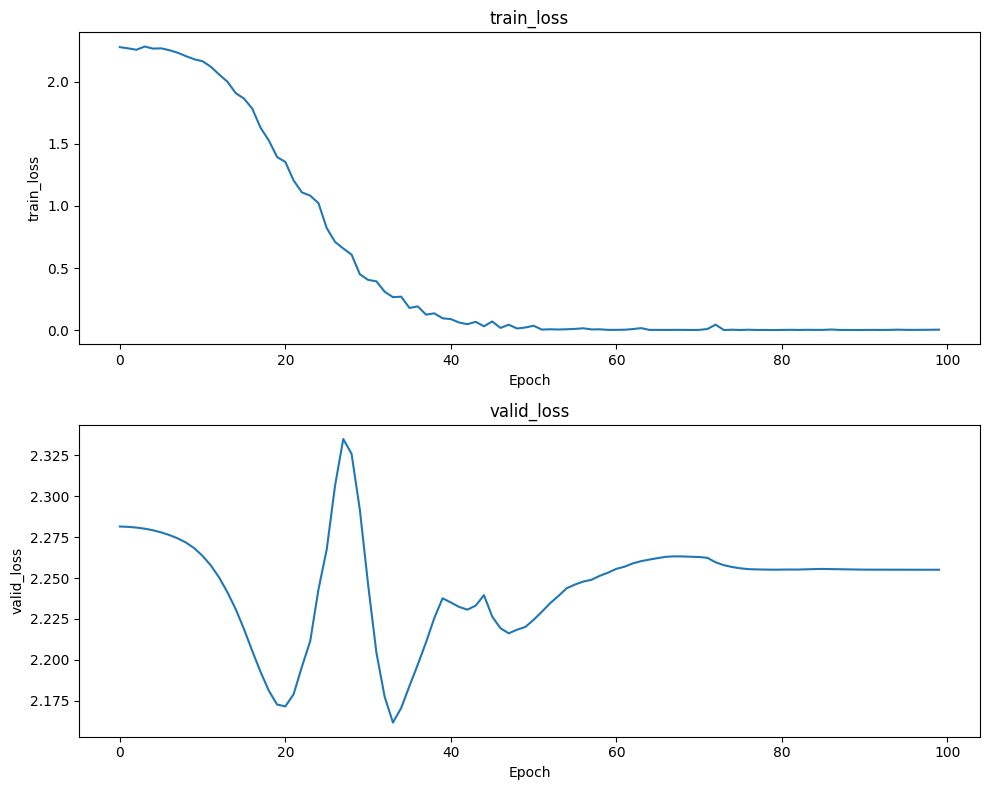

In [23]:
# Define the metrics to plot
metrics = list(history.keys())
print(f'Metrics: {metrics} \tHistory size: {len(history[metrics[0]])}')

# Plot each metric in a separate subplot
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 8))
for i, metric in enumerate(metrics):
    axs[i].plot(history[metric])
    axs[i].set_title(metric)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel(metric)
plt.tight_layout()
plt.show()